# Algoritmo Mapper

Los modelos tipo BERT (Bidirectional Encoder Representations from Transformers) son redes neuronales ampliamente utilizadas en el procesamiento de lenguaje natural (NLP) y representan el estado del arte para una variedad de tareas lingüísticas. Estos modelos, en términos generales, toman como entrada un conjunto de palabras (una oracion) y generan una serie de vectores, uno por cada palabra en la secuencia, además de un vector especial asociado a un token denominado "CLS."

Los modelos BERT se someten a un proceso de pre-entrenamiento en el que se abordan dos tareas fundamentales: modelado de lenguaje y predicción de la siguiente oración. Esto les permite capturar un profundo conocimiento de la estructura y el uso del lenguaje natural. Además, después de esta fase de pre-entrenamiento, es posible realizar fine-tuning o ajustes específicos en estos modelos para adaptarlos a tareas particulares. Este ajuste generalmente implica entrenar una capa adicional, como una capa de clasificación, en la parte superior del modelo original.

Una de las funciones destacadas de los modelos BERT es su capacidad para generar embeddings de oraciones. Esto se logra mediante el proceso de pooling, donde se obtiene el vector de representación de la oración a partir del token "CLS" en la última capa del modelo BERT. El token "CLS" contiene información condensada sobre la oración en su contexto y se utiliza como representación de toda la oración.

Los vectores generados por un modelo BERT típicamente residen en un espacio de 768 dimensiones, correspondientes a la última capa del modelo. Por lo tanto, el proceso de embedings de oraciones de un modelo BERT se puede pensar como una funcion $f: O \rightarrow \mathbb{R}^{768}$. Donde $O$ es el espacio de oraciones. Es decir, el embedding resultante de un modelo BERT consiste en transformar una oración en un vector de 768 dimensiones.

Este proyecto se enfoca en el análisis del espacio topológico de embeddings generados por un modelo BERT que ha sido fine-tuneado específicamente para la clasificación de sentimientos. El objetivo principal es explorar y comprender la estructura de este espacio. Es decir, se quiere estudiar la imagen $f(O)$ como espacio topologico. Para lograr esto, se recopilará un conjunto de datos de oraciones que expresan emociones y se calcularán los embeddings correspondientes mediante el proceso de pooling CLS en la última capa del modelo BERT fine-tuneado. Posteriormente, se aplicará el algoritmo Mapper para visualizar la estructura topológica de estos vectores en un espacio de alta dimensionalidad. Esta exploración permitirá una comprensión más profunda de cómo las representaciones de sentimientos se organizan en el espacio de embeddings y ayudará a identificar patrones o agrupamientos significativos en los datos

In [1]:
import numpy as np
import sklearn
import kmapper as km
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import cluster
import pandas as pd
from wordcloud import WordCloud
import transformers
from transformers import BertForSequenceClassification, AutoTokenizer
import torch

In [2]:
carpeta_datos = "./data/"
carpeta_output = "./output/"

name_input_file = "Emotion_final.csv"

In [3]:
# semilla random para replicar
semilla_random = 1029

np.random.seed(semilla_random)
sklearn.utils.check_random_state(semilla_random)
torch.manual_seed(semilla_random)

## Lectura y visualización de los datos

https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text

Se considera una base de datos que consiste en un conjunto de oraciones. Estas oraciones denotan alguna emoción, y se tiene una etiqueta de sentimiento asociada a cada elemento. El conjunto de datos consiste en 21,459 oraciones. Dado que se quiere estudiar el espacio de embeddings, se consideran todas esta oraciones. Para asi poder tener mas vectores en la estructura. Sin embargo, esto va a resultar en mas tiempo de ejecución requerido al hacer los embeddings de las oraciones.  

In [4]:
# leer los datos previamente descargados
df_completo = pd.read_csv(carpeta_datos+name_input_file)

# ver
print(df_completo.shape)
df_completo.head()

(21459, 2)


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
# se puede no tomar conjunto de dato completo, solo un porcentaje

# proporcion de datos a tomar
p = 1  # en este caso, considerar todo el df

# hacer el muestreo
df = df_completo.sample(frac=p, random_state= semilla_random)

# ver
print(df.shape)
df.head()

(21459, 2)


,Text,Emotion
7797,i feel heartbroken but for some reason not str...,sadness
14663,i have one toe that is starting to feel kind o...,sadness
5865,i feel honoured to become a journalist on his ...,happy
11828,when my grandmother came to stay with us perma...,anger
4511,i cant shake the im hiding how i feel about my...,happy


In [6]:
# sacar la informacion del df
oraciones = list(df['Text'].values)
emociones = df['Emotion'].values

In [7]:
# ver unas cuantas emociones
for o in oraciones[:3]:
    print(o)

i feel heartbroken but for some reason not strong enough to say i m finished with him
i have one toe that is starting to feel kind of numb
i feel honoured to become a journalist on his blog dedicated to this amazing song contest which is eurovision


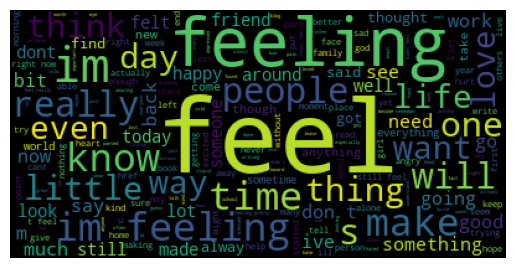

In [8]:
# unir todas las oraciones en una sola
oraciones_juntas = " ".join(oraciones)

# hacer el wordcloud
wordcloud = WordCloud().generate(oraciones_juntas)

# mostrar
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

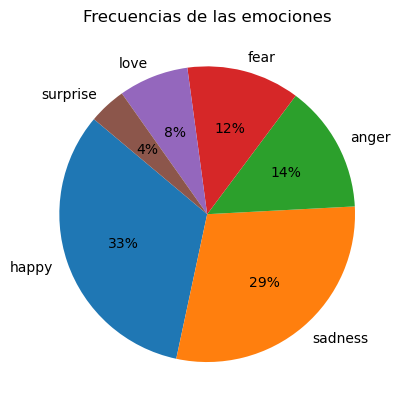

In [9]:
# calcular las frecuencias de las emociones
frecuencias_emociones = df['Emotion'].value_counts()

# tomar las emociones
emociones_unicas = list(frecuencias_emociones.index)

# hacer un grafico de pastel
plt.pie(frecuencias_emociones, labels=emociones_unicas, autopct='%1.f%%', startangle=140)

# titulo y mostrar
plt.title('Frecuencias de las emociones')
plt.show()

### Calcular los embedings de las oraciones

https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#bertforsequenceclassification

https://huggingface.co/bhadresh-savani/bert-base-uncased-emotion?text=i+think+i+dont+remember+this

In [10]:
name_modelo = "bhadresh-savani/bert-base-uncased-emotion"

tokenizer = AutoTokenizer.from_pretrained(name_modelo)
model = BertForSequenceClassification.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")

In [11]:
def vectorizar_oraciones(lista_oraciones):
    # toma una lista de oraciones
    # las vectoriza usando el modelo
    
    # placeholder
    vectores = np.array([]).reshape(0, 768)
    
    print("Vectorizando")
    
    # el proceso se debe de hacer por baches
    # pues mi computadora se queda sin memoria
    n = 5
    # iterar en los "batches"
    for i in range(0, len(lista_oraciones), n):
        
        batch = lista_oraciones[i:i+n]
        
        # obtener el resultado del batch
        # pasar las strings por el tokenizador
        inputs = tokenizer(batch,  padding=True, truncation=True, return_tensors="pt")
        
        # obtener los outputs del modelo 
        with torch.no_grad():
            outputs = model.bert(**inputs)
    
        # concatenarlo con los resultados totales        
        vectores = np.vstack((vectores, outputs.pooler_output))
        
        print(f'Progreso: [{min(i+n, len(lista_oraciones))}/{len(lista_oraciones)}]')
    
    return vectores

In [12]:
# el nombre de los vectores es con base en la proporcion usada
nombre_vectores = "Vectores_" + str(int(p*100)) + '.npy'

In [13]:
try:
    
    # intentar leer los datos
    X = np.load(carpeta_datos + nombre_vectores)
    
    # mismo numero de datos
    assert df.shape[0] == X.shape[0]
    
    print("Se leen los datos previamente vectorizados")

# si los vectores no tienen tantos elementos como el df
except AssertionError:
    print("No se tiene el numero de vectores necesarios")
    
    # se vectoriza el df
    X = vectorizar_oraciones(oraciones)
    
    # se salva
    np.save(carpeta_datos + nombre_vectores, X)
    
# si no se pueden cargar los datos
except Exception as varname:
    print(varname)
    
    # se vectoriza el df
    X = vectorizar_oraciones(oraciones)
    
    # se salva
    np.save(carpeta_datos + nombre_vectores, X)

Se leen los datos previamente vectorizados


In [14]:
print(df.shape)
print(X.shape)

(21459, 2)
(21459, 768)


## Hyperparametros del algoritmo MAPPER

In [15]:
# ------------------------------------------------------------------------------------------------

# PARA INSTANCIAR EL MAPPER

# controlar que tanta informacion se imprime al hacer el algoritmo
# puede ser:
# {0, 1, 2}
verbose_mapper = 0

# ------------------------------------------------------------------------------------------------

# PARA EL FILTRO

# funcion filtro a usar
# puede ser: 
# clases de Scikit-learn con fit_transform() (e.g sklearn.manifold.TSNE())
# una lista con numeros de las dimensiones a proyectar
# {"sum", "mean", "median", "max", "min", "std", "dist_mean", "l2norm", "knn_distance_n"}
filtro = sklearn.manifold.TSNE(init='pca', learning_rate='auto')

# despues de aplicar el filtro, se pueden re-escalar los datos
# puede ser:
# None si no se quieren re-escalar despues de la proyeccion
# default = preprocessing.MinMaxScaler()
# {preprocessing.StandardScaler(), preprocessing.RobustScaler(), preprocessing.MaxAbsScaler()}
reescalar = preprocessing.MinMaxScaler()

# para algunos filtros ("knn_distance_n") tiene sentido usar una matriz de distanicas
# esta se le puede pasar, mas bien, la metrica a usar para la matriz
# puede ser:
# [“braycurtis”, “canberra”, “chebyshev”, “cityblock”, “correlation”, “cosine”, 
# “dice”, “euclidean”, “hamming”, “jaccard”, “kulsinski”, “mahalanobis”, “matching”, 
# “minkowski”, “rogerstanimoto”, “russellrao”, “seuclidean”, “sokalmichener”,
# “sokalsneath”, “sqeuclidean”, “yule”]
# None, para usar lo datos tal cual (creo que es mejor asi, a menos que se use knn_distance_n)
metrica_distance_matrix = None

# ------------------------------------------------------------------------------------------------

# PARA LA CUBIERTA

# numero de intervalos a considerar en la cubierta
# considerando obviamente solo los valores en [min, max] (i.e la imagen)
# el numero de intervalos es el mismo para cada dimension, en caso de haber mas de una
#numero_intervalos = 15 # para el 1
numero_intervalos = 20 # # para el 100

# porcentaje en el que se intersecan dos intervalos adyacentes 
# el porcentaje se calcula solo sobre una dimension
# (0, 1)
#interseccion_intervalos = 0.5 # para el 1
interseccion_intervalos = 0.08 # para el 100


# ------------------------------------------------------------------------------------------------

# PARA CREAR EL GRAFO

# algoritmo de clusterizacion a aplicar
# {cluster.KMeans(n_clusters=n), cluster.DBSCAN(), cluster.AgglomerativeClustering(n_clusters=n)}
clusterizador = cluster.DBSCAN(metric="cosine")
#clusterizador = cluster.KMeans(n_clusters=3)

# ------------------------------------------------------------------------------------------------

# PARA VISUALIZAR EL GRAFICO

# titulo del archivo
title = "Algoritmo_Mapper_" + str(int(p*100)) 

# un array, un valor por cada elemento del conjunto de datos
# estos valores son usados para colorear los nodos
# es decir, un nodo se colorea segun los valores de sus elementos
# default: np.arange(X.shape[0])
# se pueden poner varias, de modo que seria un array X.shape[0] x num_valores_colores

dict_emociones = {'love':1, 'happy':2, 'sadness':3, 'surprise':4, 'fear':5, 'anger':6}
resultados_emociones=[]  # ir poniendo las codificaciones de los colores

# poner una codificacion que sea de todas las emociones
resultados_emociones.append([dict_emociones[e] for e in emociones])


# colorear segun la emocion, hacer 1 la emocion 'target' y 0 las demas, por cada emocion
for emocion in list(dict_emociones.keys()):
    resultados_emociones.append(np.where(emociones == emocion, 1, 0))
    
# ponerlo de la forma que se requierre
resultados_emociones=np.array(resultados_emociones).T

valores_para_color = resultados_emociones

# nombre de la funcion usada anteriormente
# si hay varias, entonces se deben poner varios nombres, una por cada una
nombre_valores_color = ['Todas'] + list(dict_emociones.keys()) 

# dado los valores de colores en un nodo,
# seleccionar cual va a ser el color del nodo
# como un tipo de pooling
# {'mean', 'std', 'median', 'max'}
# default es mean
# se pueden poner varias, en una lista
pooling_colores = ['mean', 'min',  'max']


# ------------------------------------------------------------------------------------------------

Se quiere rescatar la estructura en la que viven los embeddings, aunque este en un subconjunto de $R^{768}$, se tiene la hipotesis de que es una estructura de dimensión menor. El objetivo del experimento es estudiar esta estructura, debido a esto, se propone usar una funcion **filtro** que conserve la estructura lo mejor posible. Es decir, se usa una funcion filtro que es una funcion de reducción de dimensionalidad. Dentro de las opciones posibles, se usa tsne debido a los buenos resultados que ha demostrado, ademas de ser un algoritmo muy usado en la reducción de dimensionalidad de embeddings en NLP. La misma funcion filtro es usada en un ejemplo del algoritmo Mapper en el conjunto de datos MNIST, donde se obtienen buenos resultados. Debido a la similitud entre este ejemplo y el ejemplo con los datos de MNIST, se piensa que esta funcion filtro puede ayudar a obtener buenos resultados.

Para el algoritmo de **clustering**. Se busca un metodo para el cual no se deba de especificar de antemano el número de clústers, pues no se tiene informacion previa del problema que se pueda usar para determinar esto. Ademas, se busca un metodo para el cual se puedan considerar distancias no euclidianas. Se busca esto debido a que, para medir similitud en los embeddings se usa la similitud del coseno, por lo tanto, se quiere usar la métrica del coseno en el algoritmo de clustering. Se propone usar DBSCAN, pues cumple los requerimientos previamente descritos, ademas de que ha demostrado ser un algoritmo de clustering muy eficiente. Debido a que se quiere visualizar le estructura de los embeddings en general, tiene sentido considera un algoritmo de clusterign que tenga un enfoque de observar la densidad de las observaciones, y que pueda detectar los outliers de los datos, para no meter ruido a la visualización.

## Ejecucion del algoritmo MAPPER

In [16]:
### ------------------------------------------------------------------------------------------------

# inicializar el objeto que realiza el algoritmo mapper
mapper = km.KeplerMapper(verbose=verbose_mapper)

# ------------------------------------------------------------------------------------------------

# proyectar los datos
X_proyectado = mapper.project(X=X, projection=filtro, scaler = reescalar, 
                              distance_matrix=metrica_distance_matrix)

# ------------------------------------------------------------------------------------------------

# instanciar el objeto que hace la cubierta
cover = km.Cover(n_cubes=numero_intervalos, perc_overlap = interseccion_intervalos)

# ------------------------------------------------------------------------------------------------

# crear el grafo usando el algoritmo mapper
grafo = mapper.map(lens=X_proyectado, X=X, cover=cover, clusterer=clusterizador)

# ------------------------------------------------------------------------------------------------

# hacer el output del grafo en un archivo .html
mapper.visualize(grafo, path_html=carpeta_output+title+".html",
                title=title, color_values= valores_para_color,
                color_function_name = nombre_valores_color, 
                 node_color_function = pooling_colores,
                custom_tooltips = np.array(oraciones));

# ------------------------------------------------------------------------------------------------

C:\Users\diego\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


### Análisis del resultado

![Resultado principal](./Imagenes/Resultado.png)

El primer punto por notar es que en el grafo resultante se obtienen 2 componentes conexos de gran tamaño, casi todos los nodos del grafo se encuentran en alguno de estos componentes. Esto sugiere que los embedigns de las oraciones se pueden clasificar principalmente en dos clases. Por lo tanto, se puede inferir que se tiene oraciones de “dos tipos” en los datos, estas pueden ser “oraciones con sentimiento positivo” y “oraciones con sentimiento negativo”. 


Para analizar mas a detalle la estructura generada se va a hacer uso de las etiquetas de las oraciones, recordar que se tiene el sentimiento de cada oración, estas no fueron consideradas al usar el algoritmo MAPPER. Sin embargo, es de utilidad observar que tan cercano es el embeddings de oraciones con el mismo sentimiento. De este modo, se va a poder observar, por medio de los embedings, la forma en la que el BERT entiende las emociones.

Ver los nodos coloreados segun la cantidad de oraciones con sentimiento "happy" (izquiera) y "love" (derecha)

![Resultado principal](./Imagenes/happy-love.png)

Es interesante notar que todo el primer componente conexo grande esta conformado exclusivamente de oraciones con sentimientos “love” y “happy”. Es decir, este es el componente de “oraciones con sentimiento positivo”. Se puede observar como el sentimiento de amor esta fuertemente conectado por la felicidad, y que se puede ver incluso como una extensión de esta.

Ver los nodos coloreados segun la cantidad de oraciones con sentimiento "sadness"

![Resultado principal](./Imagenes/sad.png)

Se puede ver que las oraciones con sentimiento negativo quedan agrupadas todas entre si, y casi estan completamente divididas de los demas nodos, a excepcion de una ligera conexion que hay entre las oraciones de tristeza con el componente que esta arriba de estos. Esto se puede interpretar como que la tristeza es un sentimiento distinto a los demas, pero que aun asi existe una ligera similitud (conexion) entre este sentimiento y algun otro. Ahorita se va a ver cual es este sentimiento con el que se conecta la tristeza.

Ver los nodos coloreados segun la cantidad de oraciones con sentimiento "anger" (izquiera) y "fear" (derecha)

![Resultado principal](./Imagenes/anger-fear.png)

Se puede observar que, para el enojo y el miedo, las oraciones de estos sentimientos se encuentran concentrados en grupos. Sin embargo, hay varias conexiones entre estas dos comunidades, esto se puede interpretar como que, aunque estos sentimientos son distintos, existe una similitud entre ellos, se puede ir de uno al otro.


Notar que, los nodos correspondientes al enojo son los que se conectaban ligeramente con los nodos de tristeza, esto establece una similitud entre estas dos emociones. El enojo esta conectado a la tristeza y al miedo, y la conexión con el miedo es mayor. Estos 3 sentimientos conforman el segundo componente conexo grande, este puede ser interpretado como el “componente de emociones negativas”.

Ver los nodos coloreados segun la cantidad de oraciones con sentimiento "surprise"

![Resultado principal](./Imagenes/surprise.png)

Notar que se tiene menor cantidad de estos que de cualquier otro sentimiento, esto debido a la proporción de los datos. La mayoría de las oraciones de sorpresa se encuentran separados de los dos componentes conexos grandes. Esto se puede interpretar como que la sorpresa en diferente a todas las demás emociones. Sin embargo, hay un poco de influencia de sorpresa en los nodos asociados con el sentimiento de miedo. Esto se puede interpretar como que se esta encontrando dos tipos de sorpresa, una asociada al miedo, y otro no necesariamente asociado a este.

### Salvar el grafo resultante del Mapper, junto con las etiquetas

In [17]:
import pickle

# directorio donde se salvan los datos
directorio_salvar_datos = './export_data/'

# salvar el grafo
with open(directorio_salvar_datos + 'grafo_mapper.pkl', 'wb') as archivo:
    pickle.dump(grafo, archivo)
    
        
# salvar las etiquetas de las emociones
with open(directorio_salvar_datos + 'etiquetas_emociones.pkl', 'wb') as archivo:
    pickle.dump(emociones, archivo)
    